# Extractind data from zip file

In [138]:
import zipfile
import json
import sqlite3
import pandas as pd
import seaborn as sns

conn = sqlite3.connect("scopus.db")
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS papers_raw (
    file_id INTEGER,
    year INTEGER,
    raw_json TEXT
)
""")

conn.commit()
conn.close()

keep = "ScopusData2018-2023/2018/201800000"
zip_path = "ScopusData2018-2023.zip"
years = ["2018", "2019", "2020", "2021", "2022", "2023"]

def loader(year: int, start_id: int, end_id: int):
    conn = sqlite3.connect("scopus.db")
    cur = conn.cursor()

    with zipfile.ZipFile(zip_path, "r") as z:
        for file_id in range(start_id, end_id + 1):
            inner_path = f"ScopusData2018-2023/{year}/{file_id}"
            try:
                with z.open(inner_path) as f:
                    try:
                        obj = json.load(f)
                    except Exception:
                        continue
            except KeyError:
                continue
            raw_text = json.dumps(obj, ensure_ascii=False)
            cur.execute(
                """
                INSERT INTO papers_raw (file_id, year, raw_json)
                VALUES (?, ?, ?)
                """,
                (file_id, year, raw_text)
            )
    conn.commit()
    conn.close()




In [139]:
from pathlib import Path
sql_data_path = Path("scopus.db")
if not sql_data_path.exists():
    # 2018
    loader(2018, 201800000, 201802761)

    # 2019
    loader(2019, 201900000, 201903081)

    # 2020
    loader(2020, 202000000, 202003392)

    # 2021
    loader(2021, 202100000, 202103814)

    # 2022
    loader(2022, 202200000, 202204243)

    # 2023
    loader(2023, 202300000, 202302889)
else:
    print("sql data already esists")

sql data already esists


In [140]:
conn = sqlite3.connect("scopus.db")

df_2018 = pd.read_sql_query(
    """
    SELECT file_id, year, raw_json
    FROM papers_raw
    WHERE year = 2018
    """,
    conn
)

conn.close()

print(df_2018.shape)
print(df_2018.head())

(2762, 3)
     file_id  year                                           raw_json
0  201800000  2018  {"abstracts-retrieval-response": {"item": {"ai...
1  201800001  2018  {"abstracts-retrieval-response": {"item": {"ai...
2  201800002  2018  {"abstracts-retrieval-response": {"item": {"ai...
3  201800003  2018  {"abstracts-retrieval-response": {"item": {"ai...
4  201800004  2018  {"abstracts-retrieval-response": {"item": {"ai...


In [141]:
import sqlite3, pandas as pd
conn = sqlite3.connect("scopus.db")
#If you updated the code and want the updated scopus.db delete it first then rub this cell again.
if("df" not in globals()):
    SQL = """
    WITH base AS (
      SELECT
        file_id,
        year,

        -- basics
        json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."citation-title"') AS citation_title,
        json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.abstracts')        AS abstracts,
        json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publisher.publishername') AS publishername,
        json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.sourcetitle')             AS sourcetitle,

        /* publication_date: DD/MM/YYYY */
        CASE
          WHEN json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publicationdate.day')   IS NOT NULL
           AND json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publicationdate.month') IS NOT NULL
           AND json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publicationdate.year')  IS NOT NULL
          THEN printf('%02d/%02d/%04d',
                      CAST(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publicationdate.day')   AS INTEGER),
                      CAST(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publicationdate.month') AS INTEGER),
                      CAST(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head.source.publicationdate.year')  AS INTEGER))
          ELSE NULL
        END AS publication_date,

        /* ce:doi -> document_classification_codes */
        COALESCE(
          json_extract(raw_json,'$."abstracts-retrieval-response".item."item-info"."itemidlist"."ce:doi"'),
          (SELECT t.value
           FROM json_tree(raw_json, '$."abstracts-retrieval-response"') AS t
           WHERE t.key = 'ce:doi'
           LIMIT 1)
        ) AS document_classification_codes,

        -- counts
        json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.tail.bibliography."@refcount"') AS refcount,
        CAST(
          COALESCE(
            json_extract(raw_json,'$."abstracts-retrieval-response".coredata."citedby-count"'),
            json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."citedby-count"'),
            (SELECT t.value
             FROM json_tree(raw_json, '$."abstracts-retrieval-response"') AS t
             WHERE t.key = 'citedby-count'
             LIMIT 1)
          ) AS INTEGER
        ) AS citedbycount,

        /* allauthors_name = JSON array of "<given> <surname>" (no degrees) */
        (
          SELECT json_group_array(name_str)
          FROM (
            SELECT
              TRIM(
                TRIM(COALESCE(json_extract(a.value,'$."preferred-name"."ce:given-name"'),
                              json_extract(a.value,'$."ce:given-name"'), ''))
                || ' ' ||
                TRIM(COALESCE(json_extract(a.value,'$."preferred-name"."ce:surname"'),
                              json_extract(a.value,'$."ce:surname"'), ''))
              ) AS name_str
            FROM json_each(
              CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".authors.author'))
                WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".authors.author')
                WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".authors.author'))
                ELSE json_array()
              END
            ) AS a
            WHERE TRIM(
                    COALESCE(json_extract(a.value,'$."preferred-name"."ce:given-name"'),
                             json_extract(a.value,'$."ce:given-name"'), '') || ' ' ||
                    COALESCE(json_extract(a.value,'$."preferred-name"."ce:surname"'),
                             json_extract(a.value,'$."ce:surname"'), '')
                ) <> ''
          )
        ) AS allauthors_name,

        /* categories (subject → abbrev) */
        (
          SELECT json_group_array(json_object(subject, abbrev))
          FROM (
            SELECT DISTINCT
              json_extract(sa.value,'$."$"')        AS subject,
              json_extract(sa.value,'$."@abbrev"')  AS abbrev
            FROM (
              -- primary
              SELECT * FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response"."subject-areas"."subject-area"'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response"."subject-areas"."subject-area"')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response"."subject-areas"."subject-area"'))
                  ELSE json_array()
                END
              )
              UNION ALL
              -- fallback A
              SELECT * FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."subject-areas"."subject-area"'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."subject-areas"."subject-area"')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."subject-areas"."subject-area"'))
                  ELSE json_array()
                END
              )
              UNION ALL
              -- fallback B
              SELECT * FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."subject-areas"."subject-area"'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".coredata."subject-areas"."subject-area"')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."subject-areas"."subject-area"'))
                  ELSE json_array()
                END
              )
            ) AS sa
            WHERE subject IS NOT NULL AND abbrev IS NOT NULL
          )
        ) AS categories,

        /* creator name */
        (
          SELECT name_full
          FROM (
            SELECT TRIM(
                     COALESCE(json_extract(a.value,'$."preferred-name"."ce:given-name"'),
                              json_extract(a.value,'$."ce:given-name"'), '') || ' ' ||
                     COALESCE(json_extract(a.value,'$."preferred-name"."ce:surname"'),
                              json_extract(a.value,'$."ce:surname"'), '')
                   ) AS name_full
            FROM (
              SELECT * FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author'))
                  ELSE json_array()
                END
              )
              UNION ALL
              SELECT * FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author'))
                  ELSE json_array()
                END
              )
            ) AS a
            WHERE name_full <> ''
            LIMIT 1
          )
        ) AS creator,

        /* creator_degree */
        COALESCE(
          (
            SELECT deg FROM (
              SELECT NULLIF(TRIM(json_extract(a.value,'$."ce:degrees"')), '') AS deg
              FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author'))
                  ELSE json_array()
                END
              ) AS a
              UNION ALL
              SELECT NULLIF(TRIM(json_extract(a2.value,'$."ce:degrees"')), '') AS deg
              FROM json_each(
                CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author'))
                  WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author')
                  WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author'))
                  ELSE json_array()
                END
              ) AS a2
            )
            WHERE deg IS NOT NULL AND deg <> ''
            LIMIT 1
          ),
          (
            SELECT NULLIF(TRIM(json_extract(ag_author.value,'$."ce:degrees"')), '')
            FROM json_each(
              CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."author-group"'))
                WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."author-group"')
                WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."author-group"'))
                ELSE json_array()
              END
            ) AS ag
            JOIN json_each(
              CASE json_type(json_extract(ag.value,'$.author'))
                WHEN 'array'  THEN json_extract(ag.value,'$.author')
                WHEN 'object' THEN json_array(json_extract(ag.value,'$.author'))
                ELSE json_array()
              END
            ) AS ag_author
            WHERE NULLIF(TRIM(json_extract(ag_author.value,'$."ce:degrees"')), '') IS NOT NULL
            AND json_extract(ag_author.value,'$."@auid"') = (
              SELECT auid FROM (
                SELECT json_extract(a.value,'$."@auid"') AS auid
                FROM json_each(
                  CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author'))
                    WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author')
                    WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".item.coredata."dc:creator".author'))
                    ELSE json_array()
                  END
                ) AS a
                UNION ALL
                SELECT json_extract(a2.value,'$."@auid"') AS auid
                FROM json_each(
                  CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author'))
                    WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author')
                    WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".coredata."dc:creator".author'))
                    ELSE json_array()
                  END
                ) AS a2
              )
              WHERE auid IS NOT NULL
              LIMIT 1
            )
            LIMIT 1
          )
        ) AS creator_degree,

        /* keywords */
        (
          SELECT json_group_array(kw_src.kw)
          FROM (
            SELECT json_extract(k.value,'$."$"') AS kw
            FROM json_each(
              CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."citation-info"."author-keywords"."author-keyword"'))
                WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."citation-info"."author-keywords"."author-keyword"')
                WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response".item.bibrecord.head."citation-info"."author-keywords"."author-keyword"'))
                ELSE json_array()
              END
            ) AS k
            UNION ALL
            SELECT json_extract(k2.value,'$."$"') AS kw
            FROM json_each(
              CASE json_type(json_extract(raw_json,'$."abstracts-retrieval-response"."authkeywords"."author-keyword"'))
                WHEN 'array'  THEN json_extract(raw_json,'$."abstracts-retrieval-response"."authkeywords"."author-keyword"')
                WHEN 'object' THEN json_array(json_extract(raw_json,'$."abstracts-retrieval-response"."authkeywords"."author-keyword"'))
                ELSE json_array()
              END
            ) AS k2
          ) AS kw_src
          WHERE kw_src.kw IS NOT NULL
        ) AS keywords
      FROM papers_raw
    )
    SELECT
      base.*,
      COALESCE(json_array_length(base.allauthors_name), 0) AS allauthors_count
    FROM base
    ORDER BY year, file_id;
    """

    df = pd.read_sql_query(SQL, conn)
else:
    print("df already exists")


df already exists


# Clean data

In [142]:
df_clean = df.drop(columns=["file_id","citation_title","abstracts","document_classification_codes"])

In [143]:
#Check for na values and number of rows and columns remaining
print(df_clean.shape)
df_clean.isna().sum()

(20186, 12)


year                    0
publishername          11
sourcetitle             0
publication_date     4105
refcount              411
citedbycount            4
allauthors_name         0
categories              0
creator                 0
creator_degree      18790
keywords                0
allauthors_count        0
dtype: int64

In [144]:
#Cleaning with publicationdate
if "publication_date" in df_clean.columns:
    df_clean["publication_date"] = pd.to_datetime(df_clean["publication_date"],format="%d/%m/%Y")
    latest_date = max(df_clean["publication_date"])
    df_clean["days_from_latest_date"] = latest_date-df_clean["publication_date"]
    df_clean.drop(columns=["publication_date"],inplace=True)
    df_clean["days_from_latest_date"].value_counts()
else:
    print("Already done")
df_clean["days_from_latest_date"].value_counts()

days_from_latest_date
395 days     463
760 days     436
729 days     309
1125 days    284
364 days     269
            ... 
1906 days      1
1994 days      1
1314 days      1
1315 days      1
799 days       1
Name: count, Length: 1487, dtype: int64

In [145]:
#Cleaning for refcount. Refcount is dtype object so must be converted to int
df_clean.info()
df_clean["refcount"] = pd.to_numeric(df_clean["refcount"],errors="coerce").astype("Int64")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20186 entries, 0 to 20185
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   year                   20186 non-null  int64          
 1   publishername          20175 non-null  object         
 2   sourcetitle            20186 non-null  object         
 3   refcount               19775 non-null  object         
 4   citedbycount           20182 non-null  float64        
 5   allauthors_name        20186 non-null  object         
 6   categories             20186 non-null  object         
 7   creator                20186 non-null  object         
 8   creator_degree         1396 non-null   object         
 9   keywords               20186 non-null  object         
 10  allauthors_count       20186 non-null  int64          
 11  days_from_latest_date  16081 non-null  timedelta64[ns]
dtypes: float64(1), int64(2), object(8), timedelta6

In [146]:
#Cleaning for 'citedbycount'
float_exist=False
for v in df_clean["citedbycount"]:
    if pd.isna(v)==True:
        continue
    if v%1==0:
        continue
    else:
        float_exist=True
print(float_exist)
#Float value doesnt exist so we turn column into Int64
df_clean["citedbycount"] = df_clean["citedbycount"].astype("Int64")
df_clean.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20186 entries, 0 to 20185
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   year                   20186 non-null  int64          
 1   publishername          20175 non-null  object         
 2   sourcetitle            20186 non-null  object         
 3   refcount               19775 non-null  Int64          
 4   citedbycount           20182 non-null  Int64          
 5   allauthors_name        20186 non-null  object         
 6   categories             20186 non-null  object         
 7   creator                20186 non-null  object         
 8   creator_degree         1396 non-null   object         
 9   keywords               20186 non-null  object         
 10  allauthors_count       20186 non-null  int64          
 11  days_from_latest_date  16081 non-null  timedelta64[ns]
dtypes: Int64(2), int64(2), object(7), timede

In [148]:
#Remove outliers using 1.5 IQR method and drop missing value
df_clean = df_clean[df_clean["allauthors_count"].notna()]

iqr=df_clean["allauthors_count"].quantile(0.75)-df_clean["allauthors_count"].quantile(0.25)
min_boundary = df_clean["allauthors_count"].quantile(0.25)-1.5*iqr
max_boundary = df_clean["allauthors_count"].quantile(0.75)+1.5*iqr
df_clean = df_clean[(df_clean["allauthors_count"]<max_boundary) & (df_clean["allauthors_count"]>min_boundary)]

4.0
12
1


# Clustering data for column author_num

12
12
       allauthors_count  authors_cluster_raw authors_level
0                     2                    0           low
1                     2                    0           low
2                     4                    0           low
3                     8                    1          high
4                     6                    2        medium
...                 ...                  ...           ...
20181                 5                    2        medium
20182                 3                    0           low
20183                 1                    0           low
20184                 4                    0           low
20185                 1                    0           low

[18358 rows x 3 columns]
authors_level
low       9604
medium    5843
high      2911
Name: count, dtype: int64


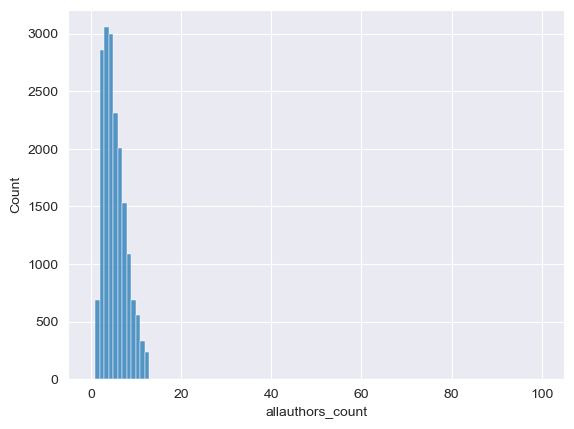

In [149]:
import numpy as np
from sklearn.cluster import KMeans
# df = pd.read_sql_query(SQL, conn)

# --- 1) KMeans on one column (number of authors) ---
X_auth = df_clean[["allauthors_count"]].values    # shape (n_samples, 1)

print(X_auth.max())

sns.histplot(df_clean[["allauthors_count"]],x="allauthors_count",stat="count",bins=100,binwidth=1,binrange=(0,100))

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean["authors_cluster_raw"] = kmeans.fit_predict(X_auth)   # values like 0,1,2

# --- 2) Sort clusters by center so we can say low/medium/high ---
centers = kmeans.cluster_centers_.flatten()             # length 3
order   = np.argsort(centers)                           # index of small → large

cluster_id_to_label = {
    order[0]: "low",
    order[1]: "medium",
    order[2]: "high"
}

df_clean["authors_level"] = df_clean["authors_cluster_raw"].map(cluster_id_to_label)

print(df_clean["allauthors_count"].max())
print(df_clean[["allauthors_count", "authors_cluster_raw", "authors_level"]])
print(df_clean["authors_level"].value_counts())

# Predict author num with xgboost classifier

In [150]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

feature_cols = ["year", "citedbycount", "refcount"]   # keep it simple first

# 1) Convert to numeric (anything weird becomes NaN)
for col in feature_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# 2) Fill missing values (needed because XGBoost hates NaN in some setups)
df_clean[feature_cols] = df_clean[feature_cols].fillna(df_clean[feature_cols].median())
y = df_clean["authors_cluster_raw"]  
# 3) Final X matrix as float
X = df_clean[feature_cols].astype(float)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.55      0.86      0.67      1921
           1       0.47      0.01      0.02       582
           2       0.38      0.21      0.27      1169

    accuracy                           0.52      3672
   macro avg       0.47      0.36      0.32      3672
weighted avg       0.48      0.52      0.44      3672

